In [2]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [33]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/g/gkrzmanc/eval_plots_EC/eval_Ks_EC_GT_clust/showers_df_evaluation/0_0_None_pandora.pt"
sd_hgb1, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/g/gkrzmanc/eval_plots_EC/eval_Ks_EC_GT_clust/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
sd_hgb.number_batch.unique()

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.362e+03, 9.364e+03,
       9.365e+03], dtype=float32)

In [34]:
len(sd_hgb), len(sd_hgb1)

(24795, 27275)

In [35]:
filter_pi = sd_hgb1.pid == -211
masses_pandora = np.sqrt(sd_hgb1.pandora_calibrated_pfo[filter_pi].values**2 - np.linalg.norm(np.array(sd_hgb1.pandora_calibrated_pos[filter_pi].values.tolist()), axis=1)**2)

/tmp/gkrzmanc/ipykernel_52040/1869114739.py:2: RuntimeWarning: invalid value encountered in sqrt
  masses_pandora = np.sqrt(sd_hgb1.pandora_calibrated_pfo[filter_pi].values**2 - np.linalg.norm(np.array(sd_hgb1.pandora_calibrated_pos[filter_pi].values.tolist()), axis=1)**2)


In [36]:
filter_pi_1 = sd_hgb.pid ==-211
masses_ML_model = np.sqrt(sd_hgb.calibrated_E[filter_pi_1].values**2 - np.linalg.norm(np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist()), axis=1)**2)

/tmp/gkrzmanc/ipykernel_52040/3362828194.py:2: RuntimeWarning: invalid value encountered in sqrt
  masses_ML_model = np.sqrt(sd_hgb.calibrated_E[filter_pi_1].values**2 - np.linalg.norm(np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist()), axis=1)**2)


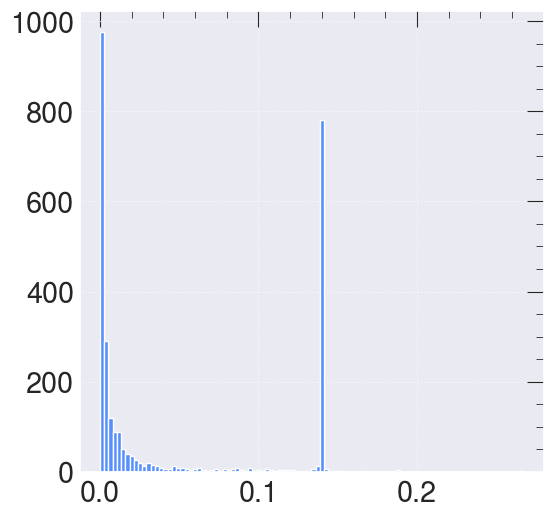

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(masses_pandora, bins=100)
fig.show()

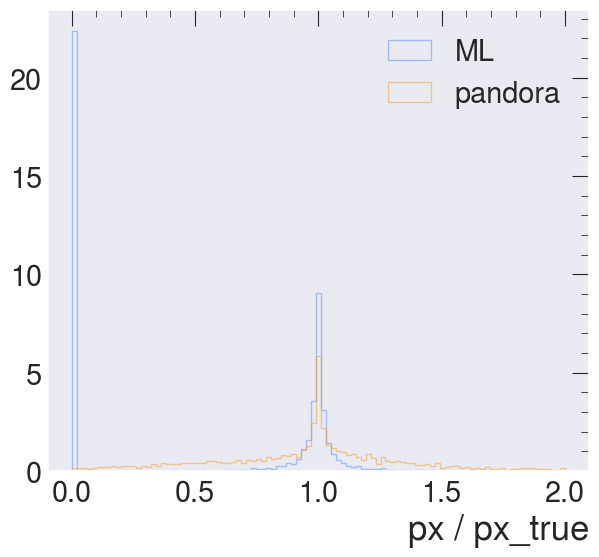

In [13]:
p_ratios = (np.linalg.norm(np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist()), axis=1) /  np.linalg.norm(np.array(sd_hgb.true_pos[filter_pi_1].values.tolist()), axis=1))
px_ratios = (np.array(sd_hgb.pred_pos_matched[filter_pi_1].values.tolist())[:,0] / np.array(sd_hgb.true_pos[filter_pi_1].values.tolist())[:,0])
px_ratios_pandora = (np.array(sd_hgb1.pandora_calibrated_pos[filter_pi].values.tolist())[:,0] / np.array(sd_hgb1.true_pos[filter_pi].values.tolist())[:,0])
pandora_is_track_in_clust = sd_hgb1.is_track_in_cluster[filter_pi].values.astype(bool)
is_track_in_cluster = sd_hgb.is_track_in_cluster[filter_pi_1].values.astype(bool)

# histogram
fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0, 2, 100)
ax.hist(px_ratios, bins=bins, label="ML", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios_pandora, bins=bins, label="pandora", alpha=0.5, histtype="step", density=True)
ax.legend()
ax.grid()
ax.set_xlabel("px / px_true")
fig.show()


In [31]:
print("Pandora:")
print(pd.Series(pandora_is_track_in_clust).value_counts(normalize=True))
print("ML:")
print(pd.Series(is_track_in_cluster).value_counts(normalize=True))

Pandora:
False    0.844639
True     0.155361
dtype: float64
ML:
True     0.554584
False    0.445416
dtype: float64


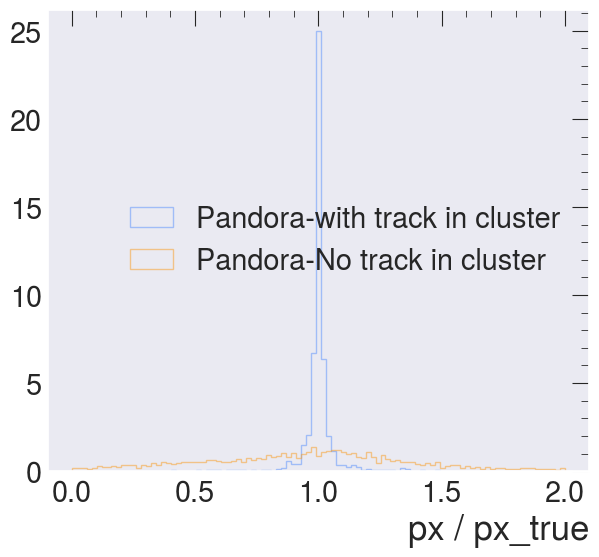

In [32]:

fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0 ,2, 100)
#ax.hist(px_ratios[is_track_in_cluster], bins=bins, label="ML-with track in cluster", alpha=0.5, density=True, histtype="step")
#ax.hist(px_ratios[~is_track_in_cluster],  bins=bins, label="ML-no track in cluster", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios_pandora[pandora_is_track_in_clust],bins=bins, label="Pandora-with track in cluster", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios_pandora[~pandora_is_track_in_clust],bins=bins, label="Pandora-No track in cluster", alpha=0.5, density=True, histtype="step")

ax.legend()
ax.grid()
ax.set_xlabel("px / px_true")

fig.show()


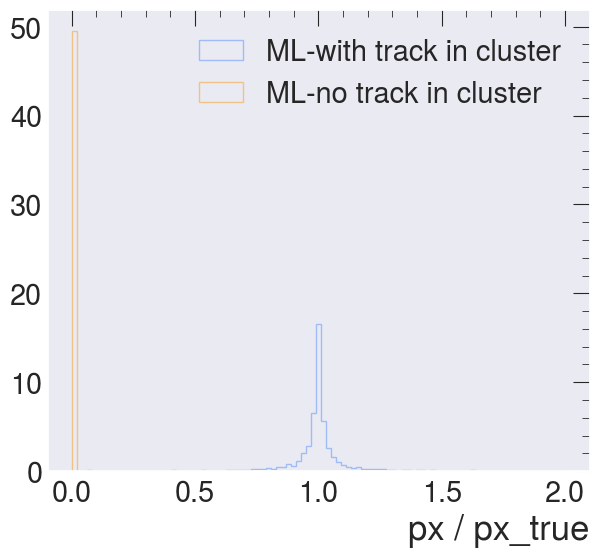

In [22]:

fig, ax = plt.subplots(figsize=(7, 6))
bins = np.linspace(0, 2, 100)
ax.hist(px_ratios[is_track_in_cluster], bins=bins, label="ML-with track in cluster", alpha=0.5, density=True, histtype="step")
ax.hist(px_ratios[~is_track_in_cluster],  bins=bins, label="ML-no track in cluster", alpha=0.5, density=True, histtype="step")

ax.legend()
ax.grid()
ax.set_xlabel("px / px_true")
fig.show()


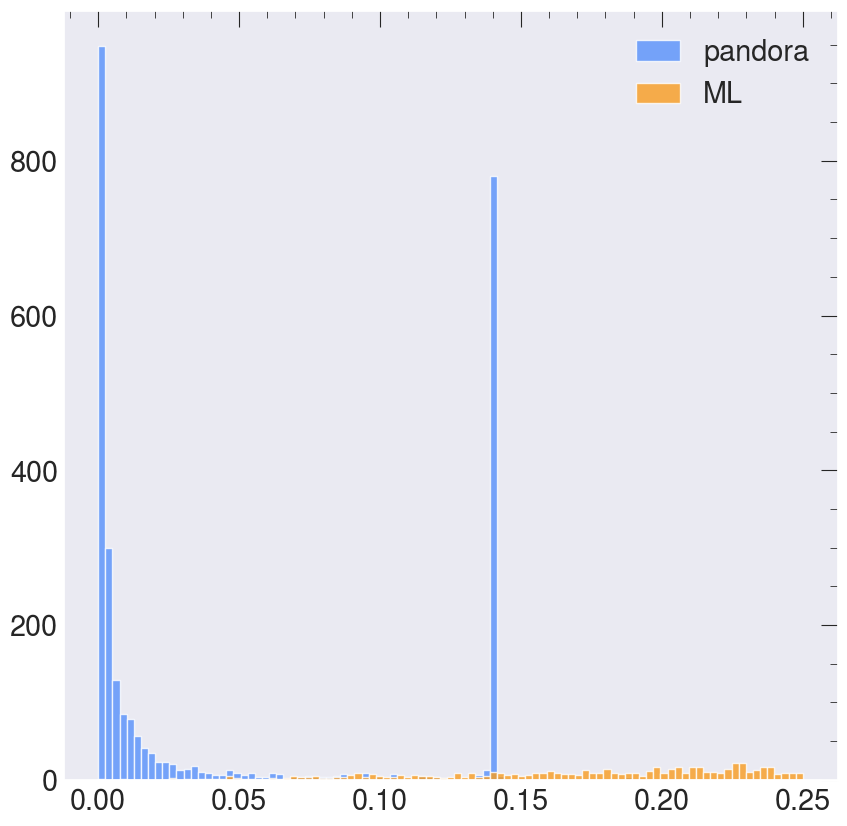

In [41]:
fig, ax = plt.subplots()
bins = np.linspace(0, 0.25, 100)
ax.hist(masses_pandora, bins=bins, label="pandora", alpha=0.8)
ax.hist(masses_ML_model, bins=bins, label="ML", alpha=0.8)
misidentified_pi_pandora = masses_pandora < 0.1
ax.legend()
ax.grid()
fig.show()

In [42]:
# print percentages of misID pi
print(np.sum(misidentified_pi_pandora) / len(misidentified_pi_pandora))

0.34992706053975203


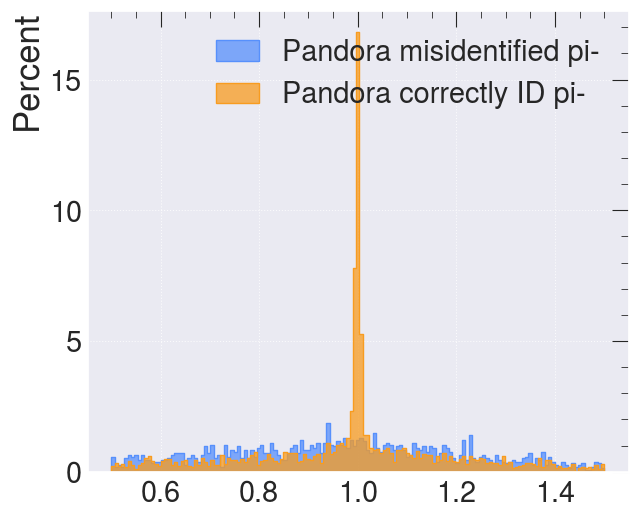

In [43]:
# Pandora filter
import seaborn as sns
bins=np.linspace(0.5, 1.5, 150)
#plt.figure() # create a bit smaller fig
plt.figure(figsize=(7, 6))
pions_pandora = (sd_hgb1[(sd_hgb1.pid==-211)].pandora_calibrated_pfo.values)/(sd_hgb1[(sd_hgb1.pid==-211)].true_showers_E.values)
sns.histplot(pions_pandora[misidentified_pi_pandora], stat="percent", label="Pandora misidentified pi-", element="step", bins=bins)
sns.histplot(pions_pandora[~misidentified_pi_pandora], stat="percent",  label="Pandora correctly ID pi-", element="step", bins=bins)
plt.legend()


In [ ]:
import seaborn as sns
bins=np.linspace(0.85, 1.15, 30)
plt.figure()
pions_pandora = (sd_hgb1[sd_hgb1.pid==211].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==211].true_showers_E.values)
pions_ml = (sd_hgb[sd_hgb.pid==211].calibrated_E.values)/(sd_hgb[sd_hgb.pid==211].true_showers_E.values)
print(pions_pandora.shape, pions_ml.shape)
sns.histplot(pions_pandora, stat="percent", bins=bins, label="pandora", element="step")
sns.histplot(pions_ml, stat="percent", bins=bins, label="ML", element="step")
#sns.histplot((sd_hgb2[sd_hgb2.pid==211].calibrated_E.values)/(sd_hgb2[sd_hgb2.pid==211].true_showers_E.values), stat="percent", bins=bins, label="ML #new", color="green")
#plt.xlim([0, 2])

plt.legend()


import seaborn as sns
plt.figure()
photons_pandora = (sd_hgb1[sd_hgb1.pid==22].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==22].true_showers_E.values)
photons_ml = (sd_hgb[sd_hgb.pid==22].calibrated_E.values)/(sd_hgb[sd_hgb.pid==22].true_showers_E.values)
sns.histplot((sd_hgb1[sd_hgb1.pid==22].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==22].true_showers_E.values), stat="percent", binwidth=0.05, label="pandora", element="step")
sns.histplot((sd_hgb[sd_hgb.pid==22].calibrated_E.values)/(sd_hgb[sd_hgb.pid==22].true_showers_E.values), stat="percent", binwidth=0.05, label="ML", element="step")
plt.xlim([0, 3])
plt.legend()
#path_hgcal = "/eos/user/g/gkrzmanc/eval_plots_EC/eval_Ks_EC_GT_model_on_pis_Ks_dataset/showers_df_evaluation/0_0_None_pandora.pt


In [ ]:
# This doesn't work right ? ?
import seaborn as sns
bins=np.linspace(0.85, 1.15, 30)
plt.figure()
pandora_good = np.abs(pions_pandora - 1) < 0.05
pandora_bad = np.abs(pions_pandora - 1) >= 0.05
sns.histplot(pions_pandora[pandora_good], stat="percent", bins=bins, label="pandora", element="step")
sns.histplot(pions_ml[pandora_good], stat="percent", bins=bins, label="ML", element="step")
#sns.histplot((sd_hgb2[sd_hgb2.pid==211].calibrated_E.values)/(sd_hgb2[sd_hgb2.pid==211].true_showers_E.values), stat="percent", bins=bins, label="ML #new", color="green")
#plt.xlim([0, 2])
plt.legend()

In [ ]:
# same with photons
sns.histplot(x=photons_pandora, y=photons_ml, bins=800)
plt.xlim([0.9, 1.1])
plt.ylim([0.9, 1.1])
plt.xlabel("pandora")
plt.ylabel("ML")
plt.show()

In [1]:
# plot a 2d hist

sns.histplot(x=pions_pandora, y=pions_ml, bins=500)
plt.xlim([0.9, 1.1])
plt.ylim([0.9, 1.1])
plt.xlabel("pandora")
plt.ylabel("ML")
plt.show()

NameError: name 'sns' is not defined

In [ ]:
import seaborn as sns
masses_pandora = np.sqrt(sd_hgb1.pandora_calibrated_pfo.values**2 - np.linalg.norm(np.array(sd_hgb1.pandora_calibrated_pos.values.tolist()), axis=1)**2)
is_pandora_pid_wrong = (masses_pandora < 0.1)
filter = (sd_hgb1.pid == -211) & (is_pandora_pid_wrong == 0)
filter1 = (sd_hgb1.pid == -211) & (is_pandora_pid_wrong == 1)
plt.figure()
#sns.histplot((sd_hgb1[sd_hgb1.pid==211].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==211].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora")
sns.histplot((sd_hgb1[filter].pandora_calibrated_pfo.values)/(sd_hgb1[filter].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora PID correct")
sns.histplot((sd_hgb1[filter1].pandora_calibrated_pfo.values)/(sd_hgb1[filter1].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora PID wrong")
# logscale
#plt.yscale("log")
plt.legend()


In [ ]:
import seaborn as sns
filter = (sd_hgb.pid == 211) & (sd_hgb.is_track_in_cluster == 0)
filter1 = (sd_hgb.pid == 211) & (sd_hgb.is_track_in_cluster == 1)
plt.figure()
#sns.histplot((sd_hgb1[sd_hgb1.pid==211].pandora_calibrated_pfo.values)/(sd_hgb1[sd_hgb1.pid==211].true_showers_E.values), stat="percent", binwidth=0.1, label="pandora")
sns.histplot((sd_hgb[filter].calibrated_E.values)/(sd_hgb[filter].true_showers_E.values), stat="percent", binwidth=0.1, label="is_track_in_cluster = 0")
sns.histplot((sd_hgb[filter1].calibrated_E.values)/(sd_hgb[filter1].true_showers_E.values), stat="percent", binwidth=0.1, label="is_track_in_cluster = 1")
# logscale
#plt.yscale("log")
plt.legend()


In [ ]:
df=sd_hgb
pandora = False
from torch_scatter import scatter_sum, scatter_mean

In [ ]:
true_e = torch.Tensor(df.true_showers_E.values)
mask_nan_true = np.isnan(df.true_showers_E.values)
true_e[mask_nan_true] = 0
batch_idx = df.number_batch

pred_E = df.calibrated_E.values
nan_mask = np.isnan(df.calibrated_E.values)
print(np.sum(nan_mask))
pred_E[nan_mask] = 0
pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
pred_vect = torch.tensor(
    np.array(df.pred_pos_matched.values.tolist()) 
)
pred_vect[nan_mask] = 0
true_vect = torch.tensor(
    np.array(df.true_pos.values.tolist())
)

true_vect[mask_nan_true] = 0
num_tracks_in_cluster = df.is_track_in_cluster.values
num_tracks_in_cluster[mask_nan_true] = 0

batch_idx = torch.tensor(batch_idx.values).long()
pred_E = torch.tensor(pred_E)
true_jet_vect = scatter_sum(true_vect, batch_idx, dim=0)
pred_jet_vect = scatter_sum(pred_vect, batch_idx, dim=0)
true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)
true_jet_p = torch.norm(true_jet_vect, dim=1)  # This is actually momentum resolution
pred_jet_p = torch.norm(pred_jet_vect, dim=1)
mass_true = torch.sqrt(torch.abs(true_E_jet**2))# - true_jet_p**2))
mass_pred = torch.sqrt(torch.abs(pred_E_jet**2 ))#- pred_jet_p**2))
mass_over_true = mass_pred / mass_true

num_tracks_in_cluster = scatter_sum(torch.tensor(num_tracks_in_cluster), batch_idx)

In [ ]:
num_tracks_in_cluster.shape

In [ ]:
df=sd_hgb1
pandora = True
from torch_scatter import scatter_sum, scatter_mean
true_e = torch.Tensor(df.true_showers_E.values)
mask_nan_true = np.isnan(df.true_showers_E.values)
true_e[mask_nan_true] = 0
batch_idx = df.number_batch
if pandora:
    pred_E = df.pandora_calibrated_pfo.values
    nan_mask = np.isnan(df.pandora_calibrated_pfo.values)
    pred_E[nan_mask] = 0
    pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
    pred_vect = torch.tensor(np.array(df.pandora_calibrated_pos.values.tolist()))
    pred_vect[nan_mask] = 0
    true_vect = torch.tensor(np.array(df.true_pos.values.tolist()))
    true_vect[mask_nan_true] = 0
else:
    pred_E = df.calibrated_E.values
    nan_mask = np.isnan(df.calibrated_E.values)
    print(np.sum(nan_mask))
    pred_E[nan_mask] = 0
    pred_e1 = torch.tensor(pred_E).unsqueeze(1).repeat(1, 3)
    pred_vect = torch.tensor(
        np.array(df.pred_pos_matched.values.tolist()) 
    )
    pred_vect[nan_mask] = 0
    true_vect = torch.tensor(
        np.array(df.true_pos.values.tolist())
    )
    true_vect[mask_nan_true] = 0

batch_idx = torch.tensor(batch_idx.values).long()
pred_E = torch.tensor(pred_E)

true_jet_vect = scatter_sum(true_vect, batch_idx, dim=0)
pred_jet_vect = scatter_sum(pred_vect, batch_idx, dim=0)
true_E_jet = scatter_sum(torch.tensor(true_e), batch_idx)
pred_E_jet = scatter_sum(torch.tensor(pred_E), batch_idx)
true_jet_p = torch.norm(true_jet_vect, dim=1)  # This is actually momentum resolution
pred_jet_p = torch.norm(pred_jet_vect, dim=1)

mass_true = torch.sqrt(torch.abs(true_E_jet**2))#- true_jet_p**2))
mass_pred_p = torch.sqrt(torch.abs(pred_E_jet**2))#- pred_jet_p**2))

mass_over_true_p = mass_pred_p / mass_true

In [ ]:
def get_decay_type(sd_hgb1):
    batch_number = sd_hgb1.number_batch.values
    decay_type_list = []
    for batch_id in range(0, int(np.max(batch_number)) + 1):
        decay_type = determine_decay_type(sd_hgb1, batch_id)
        decay_type_list.append(decay_type)
    return torch.cat(decay_type_list)

def determine_decay_type(sd_hgb1, i):
    pid_values = np.abs(sd_hgb1[sd_hgb1.number_batch == i].pid.values)
    if len(pid_values) == 2:
        decay_type = 0
        charged = np.prod(pid_values == [211.0, 211])
    elif len(pid_values) == 4:
        decay_type = 1
        neutral = np.prod(pid_values == [22.0, 22.0, 22.0, 22.0])
    else:
        decay_type = 2

    return torch.Tensor([decay_type])


In [ ]:
decay_type = get_decay_type(sd_hgb)
batch_number = sd_hgb.number_batch.values
p_zero = []
for batch_id in range(0, int(np.max(batch_number)) + 1):
    p_values = sd_hgb[sd_hgb.number_batch == batch_id].pred_pos_matched.values
    p_values1 = [np.sum(l) for l in p_values]
    sum_values = torch.sum(torch.Tensor(p_values1) == 0)>0   
    p_zero.append(torch.Tensor([sum_values]).to(bool).view(-1))

In [ ]:
mask_easy_decays = (decay_type==0)*(~torch.cat(p_zero, dim=0))

In [ ]:
decay_type = get_decay_type(sd_hgb1)

In [ ]:
print("ping")
import matplotlib.pyplot as plt
